# Random Repeated Token (RRT) experiments
Performed on BERT using the [MASK] Token

## Load BERT and model setup

In [1]:
from imports import *
utils.logging.set_verbosity_error()

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

In [12]:
n_heads = 12
n_layers = 12

# for plotting purposes
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)

## RRT with no shuffling
3 types:
- Previous instance of masked token
- Token before previous instance
- Token arfte previous instance

In [14]:
num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id

ind_score = torch.zeros((n_heads, n_layers), dtype=torch.float32)
ind_score_before = torch.zeros((n_heads, n_layers), dtype=torch.float32)
ind_score_after = torch.zeros((n_heads, n_layers), dtype=torch.float32)


for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            rand_tokens,
        ],
        dim=1,
    )
    
    # Select random token to mask
    rand_ind = random.randint(0, seq_len - 1)
    mask_ind = seq_len + rand_ind
    
    # replace token with [MASK]
    rep_tokens[0][mask_ind] = 103 
    
    # run BERT
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            ind_score[layer][head] += (mask_attn[rand_ind])
            ind_score_before[layer][head] += (mask_attn[rand_ind - 1])
            ind_score_after[layer][head] += (mask_attn[rand_ind + 1])

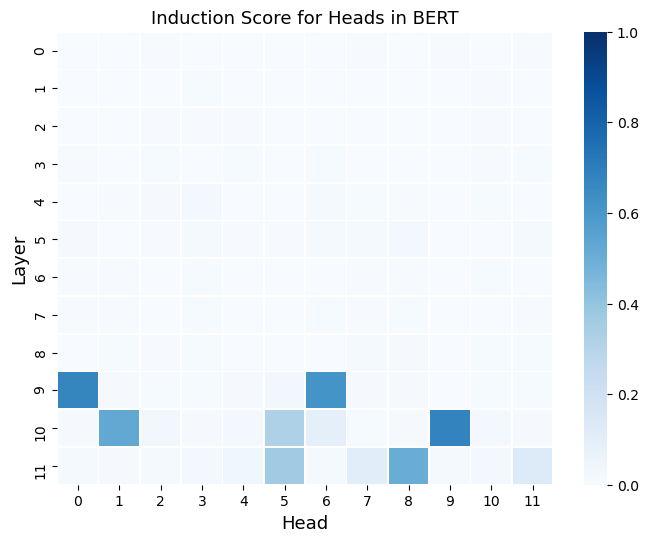

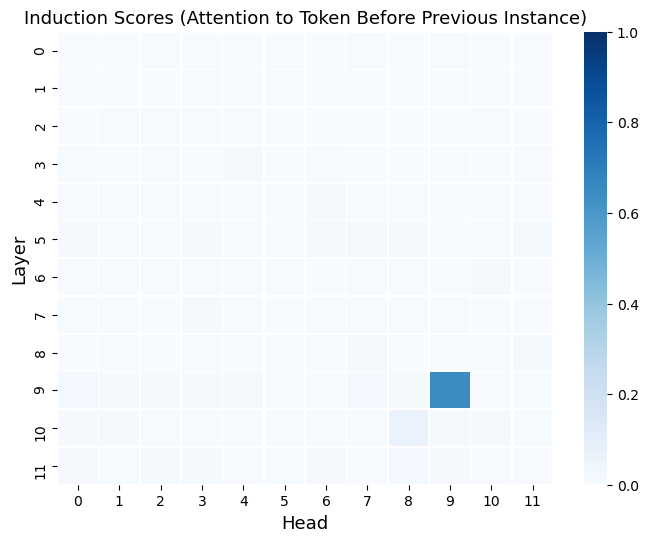

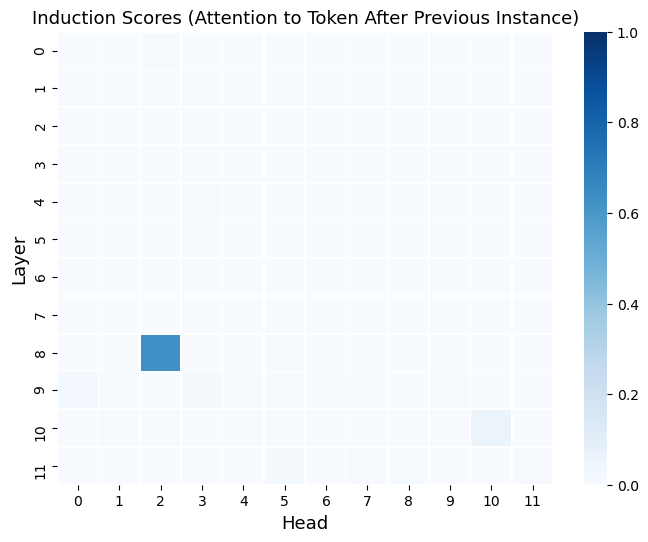

In [15]:
ind_scores_np = ind_score.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT', fontsize = 13)
plt.savefig('figs/ind_score_rrt.png', dpi = 150)

ind_scores_np = ind_score_before.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Scores (Attention to Token Before Previous Instance)', fontsize = 13)
plt.savefig('figs/ind_score_rrt_before.png', dpi = 150)

ind_scores_np = ind_score_after.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Scores (Attention to Token After Previous Instance)', fontsize = 13)
plt.savefig('figs/ind_score_rrt_after.png', dpi = 150)

## RRT with shuffling

The second set of tokens is randomly shuffled, meaning that we don't expect the model to be able to use repetition to accurately figure out what the masked token is.

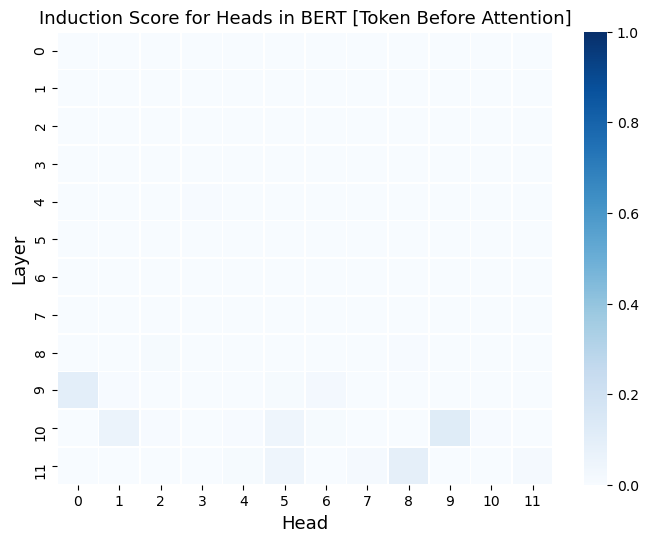

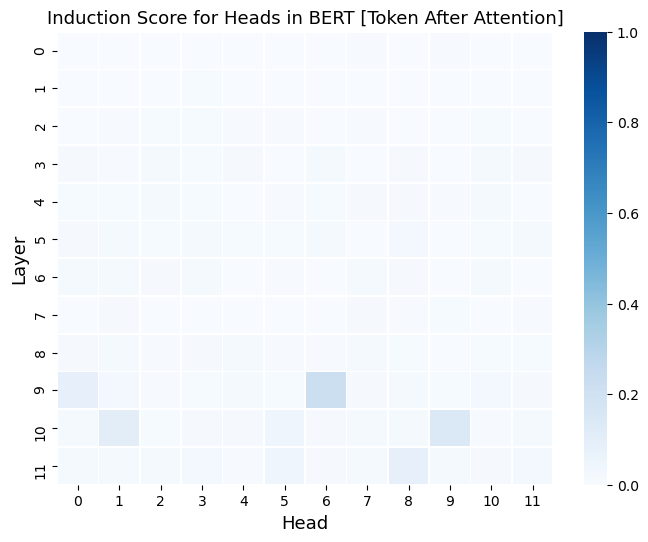

In [23]:
import random

num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id
induction_score_store_before = torch.zeros((n_heads, n_layers), dtype=torch.float32)
induction_score_store_after = torch.zeros((n_heads, n_layers), dtype=torch.float32)


for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # shuffle tokens
    idx = torch.randperm(rand_tokens.nelement())
    shuffled_tokens = rand_tokens.view(-1)[idx].view(rand_tokens.size())
    
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            shuffled_tokens,
        ],
        dim=1,
    )
    
    # Select random token to mask
    # Can run this later with masking array w/ several tokens
    mask_ind = seq_len + random.randint(0, seq_len - 1) + 1
    old_token_id = int(rep_tokens[0][mask_ind])
    old_token = ''.join(tokenizer.decode(rep_tokens[0][mask_ind]).split(" ")) # save old token
    rep_tokens[0][mask_ind] = 103 # replace token with [MASK]
    
    t = rep_tokens[0]
    before2_ind = mask_ind - 1
    before2_token = int(t[mask_ind - 1])
    before1_ind = int((t == before2_token).nonzero(as_tuple=True)[0][0])
    # before1_token = t[before1_ind]
    attend_1 = before1_ind + 1

    after2_ind = mask_ind + 1
    after2_token = int(t[mask_ind + 1])
    after1_ind = int((t == after2_token).nonzero(as_tuple=True)[0][0])
    # after1_token = t[before1_ind]
    attend_2 = after1_ind - 1
    
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            avg = mask_attn.mean()
            std = mask_attn.std()
            # z_before = (mask_attn[before1_ind] - avg)/std
            # z_after = (mask_attn[after1_ind] - avg)/std
            # induction_score_store[layer][head] += (mask_attn[attend_1] + mask_attn[attend_2])
            induction_score_store_before[layer][head] += mask_attn[attend_1]
            induction_score_store_after[layer][head] += mask_attn[attend_2]

ind_scores_np = induction_score_store_before.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT [Token Before Attention]', fontsize = 13)
plt.savefig('figs/ind_score_shuffle_before.png', dpi = 150)

ind_scores_np = induction_score_store_after.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT [Token After Attention]', fontsize = 13)
plt.savefig('figs/induction_score_store_after.png', dpi = 150)

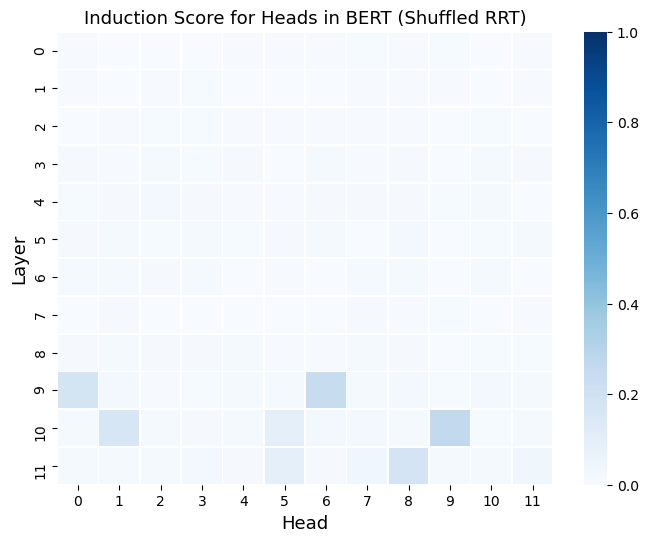

In [25]:
# Plot sum of before and after tokens 

ind_scores_before_np = induction_score_store_before.detach().numpy() / num_trials
ind_scores_after_np = induction_score_store_after.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_before_np + ind_scores_after_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT (Shuffled RRT Sum)', fontsize = 13)
plt.savefig('figs/induction_score_shuffle.png', dpi = 150)

## RRT w/ 3 repeated sequences - Bidirectional Attention

In [7]:
num_trials = 50
seq_len = 150
batch_size = 1
sep_token = 102

ind_score_triple_before = torch.zeros((n_heads, n_layers), dtype=torch.float32)
ind_score_triple_after = torch.zeros((n_heads, n_layers), dtype=torch.float32)

for i in range(num_trials):
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            rand_tokens,
            rand_tokens
        ],
        dim=1,
    )
    
    
    rand_ind = random.randint(0, seq_len - 1)
    mask_ind = seq_len + rand_ind
    rep_tokens[0][mask_ind] = 103
        
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(n_layers):
        for head in range(n_heads):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            ind_score_triple_before[layer][head] += (mask_attn[rand_ind])
            ind_score_triple_after[layer][head] += (mask_attn[seq_len*2 + rand_ind])

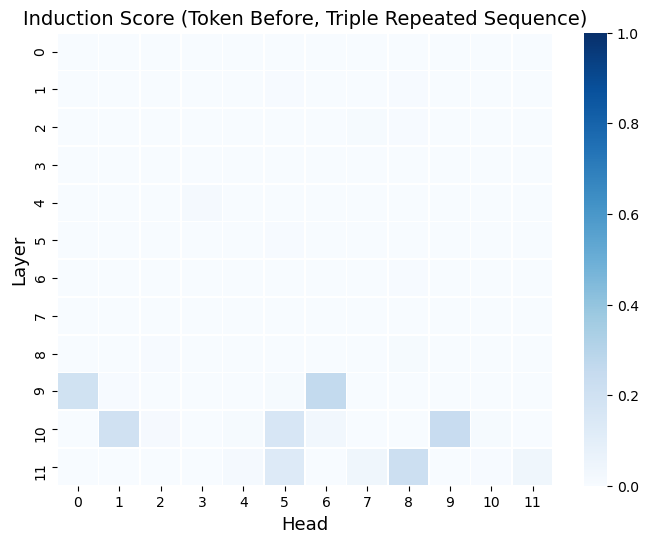

In [10]:
ind_scores_np = ind_score_triple_before.detach().numpy() / num_trials
    
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score (Token Before, Triple Repeated Sequence)', fontsize = 14)
plt.savefig('figs/ind_score_triple_before.png', dpi = 150)

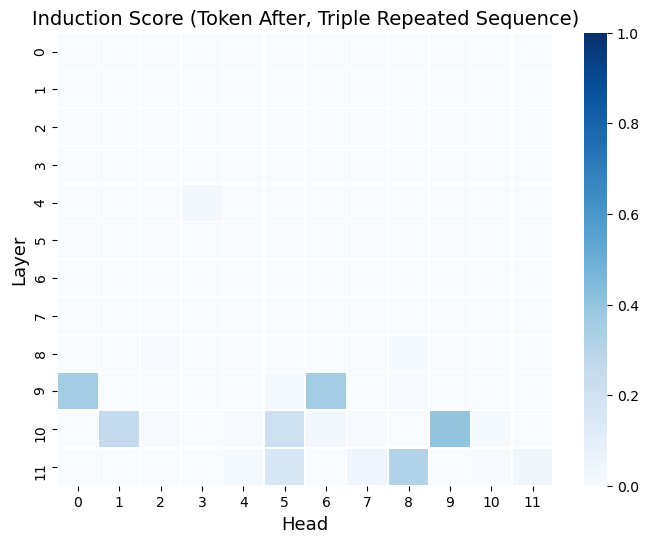

In [11]:
ind_scores_np = ind_score_triple_after.detach().numpy() / num_trials
    
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score (Token After, Triple Repeated Sequence)', fontsize = 14)
plt.savefig('figs/ind_score_triple_after.png', dpi = 150)